In [57]:
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore') # 跳过警告信息

# 读取文件
data_path = 'D:/Kaggle/FutureProcessing/'

sales_train = pd.read_csv(data_path + 'sales_train.csv')
shops = pd.read_csv(data_path + 'shops.csv')
items = pd.read_csv(data_path + 'items.csv')
item_categories = pd.read_csv(data_path + 'item_categories.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

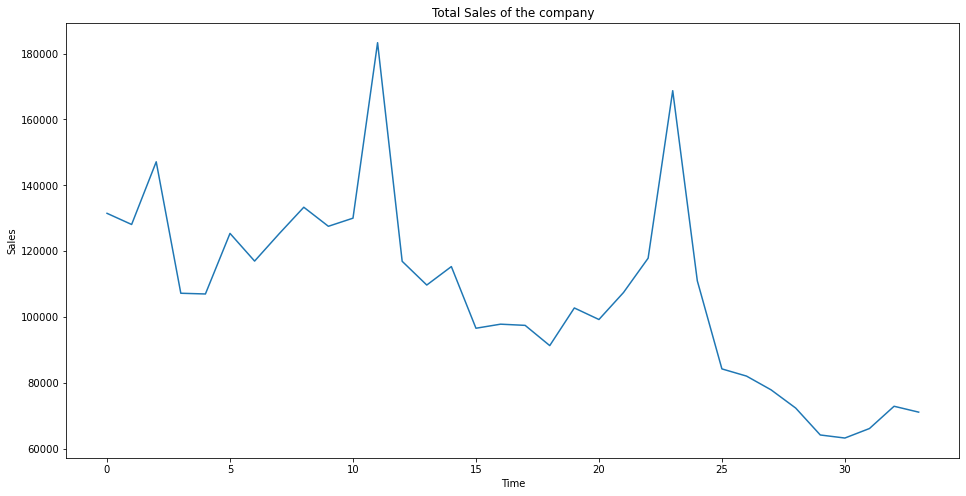

In [58]:
import matplotlib.pyplot as plt
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()  # 按月周期，求总和销售额
ts.astype('float') # 转换字符格式成浮点数，方便计算。
plt.figure(figsize=(16,8))  # 画个图
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);


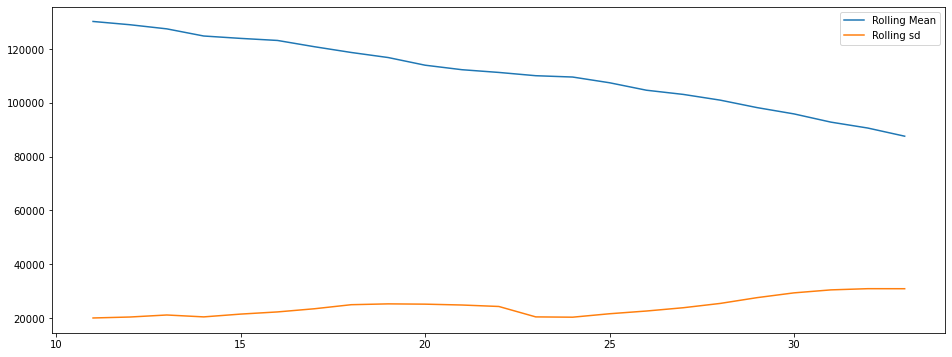

In [59]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();  

In [3]:
sales_train = sales_train.rename(columns={'date': '日期', 
                                          'date_block_num': '日期ID',
                                          'shop_id': '店铺ID',
                                          'item_id': '商品ID',
                                          'item_price': '价格',
                                          'item_cnt_day': '销售额'})

shops = shops.rename(columns={'shop_name': '店铺名',
                              'shop_id': '店铺ID'})

items = items.rename(columns={'item_name': '商品名',
                              'item_id': '商品ID',
                              'item_category_id': '商品类别ID'})

item_categories = item_categories.rename(columns=
                                         {'item_category_name': '商品类别名称',
                                          'item_category_id': '商品类别ID'})

test = test.rename(columns={'shop_id': '店铺ID',
                            'item_id': '商品ID'})

In [4]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% 压缩的'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [sales_train, shops, items, item_categories, test]
for df in all_df:
    df = downcast(df)

62.5% 压缩的
38.6% 压缩的
54.2% 压缩的
39.9% 压缩的
70.8% 压缩的


In [5]:
# 提取售价大于0的数据
sales_train = sales_train[sales_train['价格'] > 0]
# 提取售价低于5万的数据
sales_train = sales_train[sales_train['价格'] < 50000]
# 提取销售额大于0的数据
sales_train = sales_train[sales_train['销售额'] > 0]
# 提取销售额低于 1,000 的数据
sales_train = sales_train[sales_train['销售额'] < 1000]

In [6]:
print(shops['店铺名'][0], '||', shops['店铺名'][57])
print(shops['店铺名'][1], '||', shops['店铺名'][58])
print(shops['店铺名'][10], '||', shops['店铺名'][11])
print(shops['店铺名'][39], '||', shops['店铺名'][40])

!Якутск Орджоникидзе, 56 фран || Якутск Орджоникидзе, 56
!Якутск ТЦ "Центральный" фран || Якутск ТЦ "Центральный"
Жуковский ул. Чкалова 39м? || Жуковский ул. Чкалова 39м²
РостовНаДону ТРК "Мегацентр Горизонт" || РостовНаДону ТРК "Мегацентр Горизонт" Островной


In [7]:
# sales_train 修改数据中的店铺ID
sales_train.loc[sales_train['店铺ID'] == 0, '店铺ID'] = 57
sales_train.loc[sales_train['店铺ID'] == 1, '店铺ID'] = 58
sales_train.loc[sales_train['店铺ID'] == 10, '店铺ID'] = 11
sales_train.loc[sales_train['店铺ID'] == 39, '店铺ID'] = 40

# test 修改数据中的店铺ID
test.loc[test['店铺ID'] == 0, '店铺ID'] = 57
test.loc[test['店铺ID'] == 1, '店铺ID'] = 58
test.loc[test['店铺ID'] == 10, '店铺ID'] = 11
test.loc[test['店铺ID'] == 39, '店铺ID'] = 40

In [8]:
# 只提取测试数据中的店铺ID
unique_test_shop_id = test['店铺ID'].unique()
sales_train = sales_train[sales_train['店铺ID'].isin(unique_test_shop_id)]

In [9]:
shops['城市'] = shops['店铺名'].apply(lambda x: x.split()[0])

In [10]:
shops['城市'].unique()

array(['!Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
       'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
       'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [11]:
shops.loc[shops['城市'] =='!Якутск', '城市'] = 'Якутск'

In [12]:
from sklearn.preprocessing import LabelEncoder

# 创建标签编码器
label_encoder = LabelEncoder()
# 城市特征标签编码
shops['城市'] = label_encoder.fit_transform(shops['城市'])

In [13]:
# 移除店铺名称功能
shops = shops.drop('店铺名', axis=1)

shops.head()

,店铺ID,城市
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


In [14]:
# 清除商品名
items = items.drop(['商品名'], axis=1)

In [15]:
# 添加产品首次销售的日期作为特征
items['首次销售日期'] = sales_train.groupby('商品ID').agg({'日期ID': 'min'})['日期ID']

items.head()

,商品ID,商品类别ID,首次销售日期
0,0,40,NaN
1,1,76,15.0
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN


In [16]:
items[items['首次销售日期'].isna()]

,商品ID,商品类别ID,首次销售日期
0,0,40,NaN
2,2,40,NaN
3,3,40,NaN
4,4,40,NaN
5,5,40,NaN
...,...,...,...
21975,21975,61,NaN
22022,22022,40,NaN
22028,22028,40,NaN
22035,22035,40,NaN


In [17]:
# 用 34 替换首次销售日期特征的缺失值
items['首次销售日期'] = items['首次销售日期'].fillna(34)

In [18]:
# 将商品类别名的第一个单词提取为大类
item_categories['大类'] = item_categories['商品类别名称'].apply(lambda x: x.split()[0]) 

In [19]:
item_categories['大类'].value_counts()

Игры          14
Книги         13
Подарки       12
Игровые        8
Аксессуары     7
Программы      6
Музыка         6
Кино           5
Карты          5
Чистые         2
Служебные      2
PC             1
Доставка       1
Билеты         1
Элементы       1
Name: 大类, dtype: int64

In [20]:
def make_etc(x):
    if len(item_categories[item_categories['大类']==x]) >= 5:
        return x
    else:
        return 'etc'

# 如果大类的数量小于 5，则替换为 'etc'
item_categories['大类'] = item_categories['大类'].apply(make_etc)

In [21]:
item_categories.head()

,商品类别名称,商品类别ID,大类
0,PC - Гарнитуры/Наушники,0,etc
1,Аксессуары - PS2,1,Аксессуары
2,Аксессуары - PS3,2,Аксессуары
3,Аксессуары - PS4,3,Аксессуары
4,Аксессуары - PSP,4,Аксессуары


In [22]:
# 创建标签编码器
label_encoder = LabelEncoder()
# 大类特征标签编码
item_categories['大类'] = label_encoder.fit_transform(item_categories['大类'])

# 清除商品类别名称
item_categories = item_categories.drop('商品类别名称', axis=1)

In [23]:
from itertools import product

train = []
# 创建日期 ID、店铺ID 和商品 ID 的组合
for i in sales_train['日期ID'].unique():
    all_shop = sales_train.loc[sales_train['日期ID']==i, '店铺ID'].unique()
    all_item = sales_train.loc[sales_train['日期ID']==i, '商品ID'].unique()
    train.append(np.array(list(product([i], all_shop, all_item))))

idx_features = ['日期ID', '店铺ID', '商品ID'] # 基准特征
train = pd.DataFrame(np.vstack(train), columns=idx_features)

In [24]:
group = sales_train.groupby(idx_features).agg({'销售额': 'sum',
                                               '价格': 'mean'})
group = group.reset_index()
group = group.rename(columns={'销售额': '总销售额', '价格': '平均售价'})

train = train.merge(group, on=idx_features, how='left')

train.head()

,日期ID,店铺ID,商品ID,总销售额,平均售价
0,0,59,22154,1.0,999.0
1,0,59,2552,NaN,NaN
2,0,59,2554,NaN,NaN
3,0,59,2555,NaN,NaN
4,0,59,2564,NaN,NaN


In [25]:
import gc

del group
gc.collect();

In [26]:
# 添加销售数量
group = sales_train.groupby(idx_features).agg({'销售额': 'count'})
group = group.reset_index()
group = group.rename(columns={'销售额': '销售数量'})

train = train.merge(group, on=idx_features, how='left')

del group, sales_train
gc.collect()

train.head()

,日期ID,店铺ID,商品ID,总销售额,平均售价,销售数量
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,NaN,NaN,NaN
2,0,59,2554,NaN,NaN,NaN
3,0,59,2555,NaN,NaN,NaN
4,0,59,2564,NaN,NaN,NaN


In [27]:
# 将测试数据日期ID设置为34
test['日期ID'] = 34

# train与test连接
all_data = pd.concat([train, test.drop('ID', axis=1)],
                     ignore_index=True,
                     keys=idx_features)
# 用0替换缺失值
all_data = all_data.fillna(0)

all_data.head()

,日期ID,店铺ID,商品ID,总销售额,平均售价,销售数量
0,0,59,22154,1.0,999.0,1.0
1,0,59,2552,0.0,0.0,0.0
2,0,59,2554,0.0,0.0,0.0
3,0,59,2555,0.0,0.0,0.0
4,0,59,2564,0.0,0.0,0.0


In [28]:
# 合并其余数据
all_data = all_data.merge(shops, on='店铺ID', how='left')
all_data = all_data.merge(items, on='商品ID', how='left')
all_data = all_data.merge(item_categories, on='商品类别ID', how='left')

all_data = downcast(all_data)

del shops, items, item_categories
gc.collect();

59.6% 压缩的


In [30]:
def add_mean_features(df, mean_features, idx_features):
    # 检查基本特征
    assert (idx_features[0] == '日期ID') and \
           len(idx_features) in [2, 3]
    
    # 设置派生特征名称
    if len(idx_features) == 2:
        feature_name = idx_features[1] + '平均销售量'
    else:
        feature_name = idx_features[1] + ' ' + idx_features[2] + '平均销售量'
    
    # 通过基于功能的分组查找平均每月销售额
    group = df.groupby(idx_features).agg({'总销售额': 'mean'})
    group = group.reset_index()
    group = group.rename(columns={'总销售额': feature_name})
    
    # 合并df和group
    df = df.merge(group, on=idx_features, how='left')

    df = downcast(df, False)
    # 将新创建的 feature_name 特征添加到 mean_features 列表中
    mean_features.append(feature_name)

    del group
    gc.collect()
    
    return df, mean_features

In [31]:
# 派生功能名称列表，包括分组条件功能中的“商品 ID”
item_mean_features = []

# 创建按 ['日期ID', '商品 ID'] 分组的月平均销售衍生功能
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['日期ID', '商品ID'])

# 创建从按 ['日期ID', '商品ID', '城市']分组的月平均销售额派生的特征
all_data, item_mean_features = add_mean_features(df=all_data,
                                                 mean_features=item_mean_features,
                                                 idx_features=['日期ID', '商品ID', '城市'])

In [32]:
# 派生特征名称列表，包括分组条件特征中的“店铺 ID”
shop_mean_features = []

# 创建从按 ['日期ID', '店铺ID', '商品类别ID'] 分组的月平均销售额派生的特征
all_data, shop_mean_features = add_mean_features(df=all_data, 
                                                 mean_features=shop_mean_features,
                                                 idx_features=['日期ID', '店铺ID', '商品类别ID'])

In [33]:
def add_lag_features(df, lag_features_to_clip, idx_features, 
                     lag_feature, nlags=3, clip=False):
    # 只复制时差处理生成所需的DataFrame部分
    df_temp = df[idx_features + [lag_feature]].copy() 

    # 时差比对生成
    for i in range(1, nlags+1):
        #时差特征名称
        lag_feature_name = lag_feature +'_时差' + str(i)
        # 设置 df_temp 列名
        df_temp.columns = idx_features + [lag_feature_name]
        # df temp的date block num feature加1
        df_temp['日期ID'] += i
        # 基于 idx_feature 合并 df 和 df_temp
        df = df.merge(df_temp.drop_duplicates(), 
                      on=idx_features, 
                      how='left')
        # 以0替代缺失值
        df[lag_feature_name] = df[lag_feature_name].fillna(0)
        # 将限制在0~20之间的时差特征添加到lag features to clip
        if clip: 
            lag_features_to_clip.append(lag_feature_name)
    
    df = downcast(df, False)

    del df_temp
    gc.collect()
    
    return df, lag_features_to_clip

In [34]:
lag_features_to_clip = [] # 要限制在 0 到 20 之间的时差特征名称列表。
idx_features = ['日期ID', '店铺ID', '商品ID'] # 基本特征

# 根据 idx_features 创建三个月的总销售额时差特征
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='总销售额', 
                                                  nlags=3,
                                                  clip=True)

In [35]:
all_data.head().T

,0,1,2,3,4
日期ID,0.000000,0.000000,0.000000,0.000000,0.000000
店铺ID,59.000000,59.000000,59.000000,59.000000,59.000000
商品ID,22154.000000,2552.000000,2554.000000,2555.000000,2564.000000
总销售额,1.000000,0.000000,0.000000,0.000000,0.000000
平均售价,999.000000,0.000000,0.000000,0.000000,0.000000
销售数量,1.000000,0.000000,0.000000,0.000000,0.000000
城市,30.000000,30.000000,30.000000,30.000000,30.000000
商品类别ID,37.000000,58.000000,58.000000,56.000000,59.000000
首次销售日期,0.000000,0.000000,0.000000,0.000000,0.000000
大类,5.000000,7.000000,7.000000,7.000000,7.000000


In [36]:
lag_features_to_clip

['总销售额_时差1', '总销售额_时差2', '总销售额_时差3']

In [37]:
# 根据 idx_features 创建销售特征的三个月时差特征
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='销售数量', 
                                                  nlags=3)

# 基于 idx_features 创建平均售价特征的三个月时差特征
all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                  lag_features_to_clip=lag_features_to_clip,
                                                  idx_features=idx_features,
                                                  lag_feature='平均售价', 
                                                  nlags=3)

In [38]:
X_test_temp = all_data[all_data['日期ID'] == 34]
X_test_temp[item_mean_features].sum()

商品ID平均销售量       0.0
商品ID 城市平均销售量    0.0
dtype: float32

In [39]:
# 根据 idx_features 通过 item_mean_features 元素创建时差特征
for item_mean_feature in item_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data, 
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=idx_features, 
                                                      lag_feature=item_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# item_mean_features 特征移除
all_data = all_data.drop(item_mean_features, axis=1)

In [40]:
shop_mean_features

['店铺ID 商品类别ID平均销售量']

In [41]:
# 根据['日期ID', '店铺ID', '商品类别ID']为每个 shop_mean_features 元素创建时差特征
for shop_mean_feature in shop_mean_features:
    all_data, lag_features_to_clip = add_lag_features(df=all_data,
                                                      lag_features_to_clip=lag_features_to_clip, 
                                                      idx_features=['日期ID', '店铺ID', '商品类别ID'], 
                                                      lag_feature=shop_mean_feature, 
                                                      nlags=3,
                                                      clip=True)
# shop_mean_features 移除
all_data = all_data.drop(shop_mean_features, axis=1)

In [42]:
# 删除日期 ID 小于 3 的数据
all_data = all_data.drop(all_data[all_data['日期ID'] < 3].index)

In [43]:
all_data['总销售额时差平均值'] = all_data[['总销售额_时差1',
                                         '总销售额_时差2', 
                                         '总销售额_时差3']].mean(axis=1)

In [44]:
# 0到20之间的限制值
all_data[lag_features_to_clip + ['总销售额', '总销售额时差平均值']] = all_data[lag_features_to_clip +['总销售额', '总销售额时差平均值']].clip(0, 20)

In [45]:
all_data['时差变化量1'] = all_data['总销售额_时差1']/all_data['总销售额_时差2']
all_data['时差变化量1'] = all_data['时差变化量1'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

all_data['时差变化量2'] = all_data['总销售额_时差2']/all_data['总销售额_时差3']
all_data['时差变化量2'] = all_data['时差变化量2'].replace([np.inf, -np.inf], 
                                                        np.nan).fillna(0)

In [46]:
all_data['未知'] = all_data['首次销售日期'] == all_data['日期ID']

In [47]:
all_data['初销期'] = all_data['日期ID'] - all_data['首次销售日期']

In [48]:
all_data['月'] = all_data['日期ID']%12

In [49]:
# 删除首次销售日期、平均销售价格和销售数量
all_data = all_data.drop(['首次销售日期', '平均售价', '销售数量'], axis=1)

In [50]:
all_data = downcast(all_data, False)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8029765 entries, 827196 to 8856960
Data columns (total 31 columns):
 #   Column                Dtype  
---  ------                -----  
 0   日期ID                  int8   
 1   店铺ID                  int8   
 2   商品ID                  int16  
 3   总销售额                  int8   
 4   城市                    int8   
 5   商品类别ID                int8   
 6   大类                    int8   
 7   总销售额_时差1              int8   
 8   总销售额_时差2              int8   
 9   总销售额_时差3              int8   
 10  销售数量_时差1              int8   
 11  销售数量_时差2              int8   
 12  销售数量_时差3              int8   
 13  平均售价_时差1              float32
 14  平均售价_时差2              float32
 15  平均售价_时差3              float32
 16  商品ID平均销售量_时差1         float32
 17  商品ID平均销售量_时差2         float32
 18  商品ID平均销售量_时差3         float32
 19  商品ID 城市平均销售量_时差1      float32
 20  商品ID 城市平均销售量_时差2      float32
 21  商品ID 城市平均销售量_时差3      float32
 22  店铺ID 商品类别ID平均销售量_时差1  float32
 23  店铺

In [51]:
# 训练数据（特征）
X_train = all_data[all_data['日期ID'] < 33]
X_train = X_train.drop(['总销售额'], axis=1)
# 验证数据（特征）
X_valid = all_data[all_data['日期ID'] == 33]
X_valid = X_valid.drop(['总销售额'], axis=1)
# 测试数据（特征）
X_test = all_data[all_data['日期ID'] == 34]
X_test = X_test.drop(['总销售额'], axis=1)

# 训练数据（目标值）
y_train = all_data[all_data['日期ID'] < 33]['总销售额']
# 验证数据（目标值）
y_valid = all_data[all_data['日期ID'] == 33]['总销售额']

del all_data
gc.collect();

In [52]:
import lightgbm as lgb

# lgb 超参数
params = {'metric': 'rmse',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise' : True,
          'random_state': 10}

cat_features = ['店铺ID', '城市', '商品类别ID', '大类', '月']

# lgb 训练和验证数据集
dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid)
 
# LightGBM 模型训练
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)      

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 3625
[LightGBM] [Info] Number of data points in the train set: 7593847, number of used features: 30
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.307756
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01921	valid_1's rmse: 0.91337
[200]	training's rmse: 0.914479	valid_1's rmse: 0.840705
[300]	training's rmse: 0.862209	valid_1's rmse: 0.811963
[400]	training's rmse: 0.833442	valid_1's rmse: 0.800418
[500]	training's rmse: 0.814265	valid_1's rmse: 0.796865
[600]	training's rmse: 0.800503	valid_1's rmse: 0.795656
[700]	training's rmse: 0.790099	valid_1's rmse: 0.795101
[800]	training's rmse: 0.781689	valid_1's rmse: 0.795099
[900]	training's rmse: 0.774561	valid_1's rmse: 0.795493
Early stopping, best iteration is:
[827]	training's rmse: 0.779724	valid_1's rmse: 0.

In [53]:
preds = lgb_model.predict(X_test).clip(0,20)

submission['item_cnt_month'] = preds
submission.to_csv('submission.csv', index=False)

In [55]:
submission

,ID,item_cnt_month
0,0,0.453626
1,1,0.471167
2,2,0.761525
3,3,0.424044
4,4,1.619355
...,...,...
214195,214195,0.086222
214196,214196,0.033380
214197,214197,0.053082
214198,214198,0.023775
